In [28]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [12]:
mnist['data'].shape, mnist['target'].shape

((70000, 784), (70000,))

In [2]:
def relu(x):
    
    return np.maximum(0, x)

In [3]:
x = np.array([0.1, -0.9, 0.5])
relu(x)

array([0.1, 0. , 0.5])

In [4]:
def softmax(x):
    
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [6]:
def cross_entropy_error(y, t):
    
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [7]:
def softmax_loss(X, t):
    
    y = softmax(X)
    return cross_entropy_error(y, t)

In [40]:
def init_network():
    
    network = {}
    network['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network['b1'] = np.array([0.1, 0.2, 0.3])
    network['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network['b2'] = np.array([0.1, 0.2])
    network['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network['b3'] = np.array([0.1, 0.2])
    return network

def forward(network, x):
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = relu(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = relu(a2)
    y = np.dot(z2, W3) + b3
    return y

network = init_network()
x = np.array([1.0, 0.5])
forward(network, x)

array([0.426, 0.912])

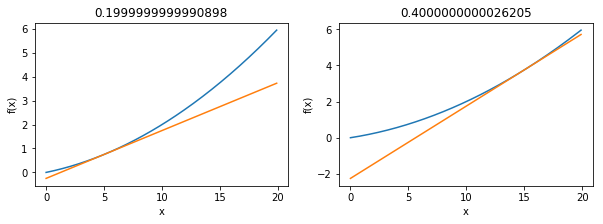

In [26]:
def numerical_diff(f, x):
    
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

def function_1(x):
    
    return 0.01*x**2 + 0.1*x 

def tangent_line(f, x):
    
    d = numerical_diff(f, x)
    y = f(x) - d*x
    return d, lambda t: d*t + y
     
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

x = np.arange(0, 20, 0.1)
y = function_1(x)
d, tf = tangent_line(function_1, 5)
y2 = tf(x)
axs[0].plot(x, y)
axs[0].plot(x, y2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_title(d)

d, tf = tangent_line(function_1, 15)
y2 = tf(x)
axs[1].plot(x, y)
axs[1].plot(x, y2)
axs[1].set_xlabel('x')
axs[1].set_ylabel('f(x)')
axs[1].set_title(d)

plt.show()

In [35]:
def function_2(x):
    
    return x[0]**2+x[1]**2

def numerical_gradient(f, x):
    
    h = 1e-4
    grad = np.zeros_like(x) # xと同じ形状の配列
    
    for idx in range(x.size):
        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad

In [38]:
numerical_gradient(function_2, np.array([3.0, 4.0])), numerical_gradient(function_2, np.array([0.0, 2.0]))

(array([6., 8.]), array([0., 4.]))

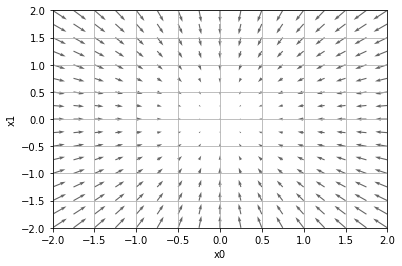

In [30]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]))

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()

In [41]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    
    x = init_x
    
    for i in range(step_num):
        
        grad = numerical_gradient(f, x)
        x -= lr*grad
        
    return x

In [42]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=0.1)

array([-6.11110793e-10,  8.14814391e-10])

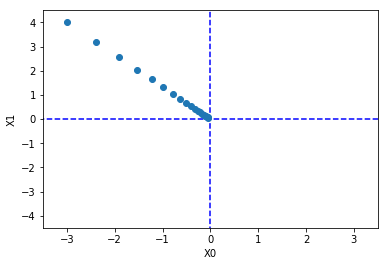

In [53]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    
    x = init_x
    x_history = []

    for i in range(step_num):
        
        x_history.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr*grad

    return x, np.array(x_history)

init_x = np.array([-3.0, 4.0])    

x, x_history = gradient_descent(function_2, init_x, lr=0.1, step_num=20)

plt.plot([-5, 5], [0,0], '--b')
plt.plot([0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()